# OC Data Scientist : Concevez une application au service de la santé publique

## Objectif

L'agence "Santé publique France" a lancé un appel à projets pour trouver des idées innovantes d’applications en lien avec l'alimentation. Vous souhaitez y participer et proposer une idée d’application.

## Ressources

La source de données est téléchargeable depuis le site : https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv

# 1. Lancement

## 1.1 Initialisation

In [1]:
# librairies de base
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from collections import Counter
import re
import os
pd.options.mode.chained_assignment = None

In [2]:
# librairies de machine learning
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
from functions import *
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score

In [3]:
# librairies de dataviz
import seaborn as sns
import missingno as msno
sns.set()
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
import matplotlib.path as path
from functions import plot_dendrogram

In [4]:
# Option d'affichage
pd.set_option("display.max_rows", 2000)
pd.set_option("display.max_columns", 2000)

In [5]:
# Chargement des données
data = pd.read_csv('foodfact_product.csv', sep='\t')

/Users/alexandredelaguillaumie/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
print(pd.show_versions())


INSTALLED VERSIONS
------------------
commit           : 945c9ed766a61c7d2c0a7cbb251b6edebf9cb7d5
python           : 3.9.7.final.0
python-bits      : 64
OS               : Darwin
OS-release       : 21.3.0
Version          : Darwin Kernel Version 21.3.0: Wed Jan  5 21:37:58 PST 2022; root:xnu-8019.80.24~20/RELEASE_X86_64
machine          : x86_64
processor        : i386
byteorder        : little
LC_ALL           : None
LANG             : fr_FR.UTF-8
LOCALE           : fr_FR.UTF-8

pandas           : 1.3.4
numpy            : 1.20.3
pytz             : 2021.3
dateutil         : 2.8.2
pip              : 21.2.4
setuptools       : 58.0.4
Cython           : 0.29.24
pytest           : 6.2.4
hypothesis       : None
sphinx           : 4.2.0
blosc            : None
feather          : None
xlsxwriter       : 3.0.1
lxml.etree       : 4.6.3
html5lib         : 1.1
pymysql          : None
psycopg2         : None
jinja2           : 2.11.3
IPython          : 7.29.0
pandas_datareader: None
bs4           

## 1.2 Overview des données

In [7]:
# Pourcentage de données manquantes
print('Au global, le taux de données renseignées est de {}%.'.format(round(data.count().sum()/data.shape[0])))

Au global, le taux de données renseignées est de 39%.


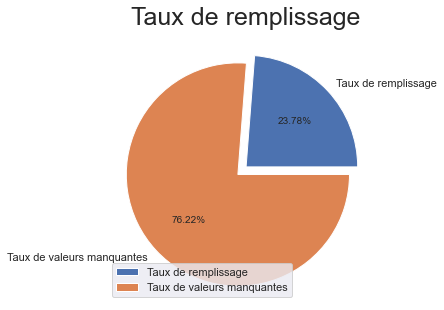

In [8]:
# Afficher le pourcentage de données global du DataFrame
def FillRate(data):
    filled_data = data.count().sum()
    row,col=data.shape
    fill_rate=filled_data/(row*col)*100   
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.title("Taux de remplissage", fontsize=25) 
    ax.axis("equal") 
    ax.pie([fill_rate, 100 - fill_rate], labels=["Taux de remplissage", "Taux de valeurs manquantes"],autopct='%1.2f%%',explode=(0,0.1),radius=1)
    plt.legend(["Taux de remplissage", "Taux de valeurs manquantes"])
    
FillRate(data)

In [9]:
print("Format du dataset :", data.shape, f", soit {data.shape[0]} lignes et {data.shape[1]} colonnes.")

Format du dataset : (320772, 162) , soit 320772 lignes et 162 colonnes.


In [10]:
# Synthèse structure des données 
def DataStructure(data):
    type_of_variable = data.dtypes.value_counts()

    Nombre_variables_numeriques =type_of_variable[type_of_variable.index=='float64'][0]

    dict_structure = {'Nombre de lignes':data.shape[0], 'Nombre de colonnes':int(data.shape[1]), 
                      'Nombre de variables catégorielles':int(type_of_variable[type_of_variable.index=='object'][0]),
                      'Nombre de variables numériques ':int(Nombre_variables_numeriques),
                      'Pourcentage de données manquantes':int((data.isnull().sum()/len(data)*100).mean()),
                      'Nombre de doublons':int(len(data[data.duplicated()]))}

    structure_data=pd.DataFrame(list(dict_structure.items()),columns=['Caractéristiques','Valeurs'])
    return structure_data

DataStructure(data)

,Caractéristiques,Valeurs
0,Nombre de lignes,320772
1,Nombre de colonnes,162
2,Nombre de variables catégorielles,56
3,Nombre de variables numériques,106
4,Pourcentage de données manquantes,76
5,Nombre de doublons,0


<AxesSubplot:>

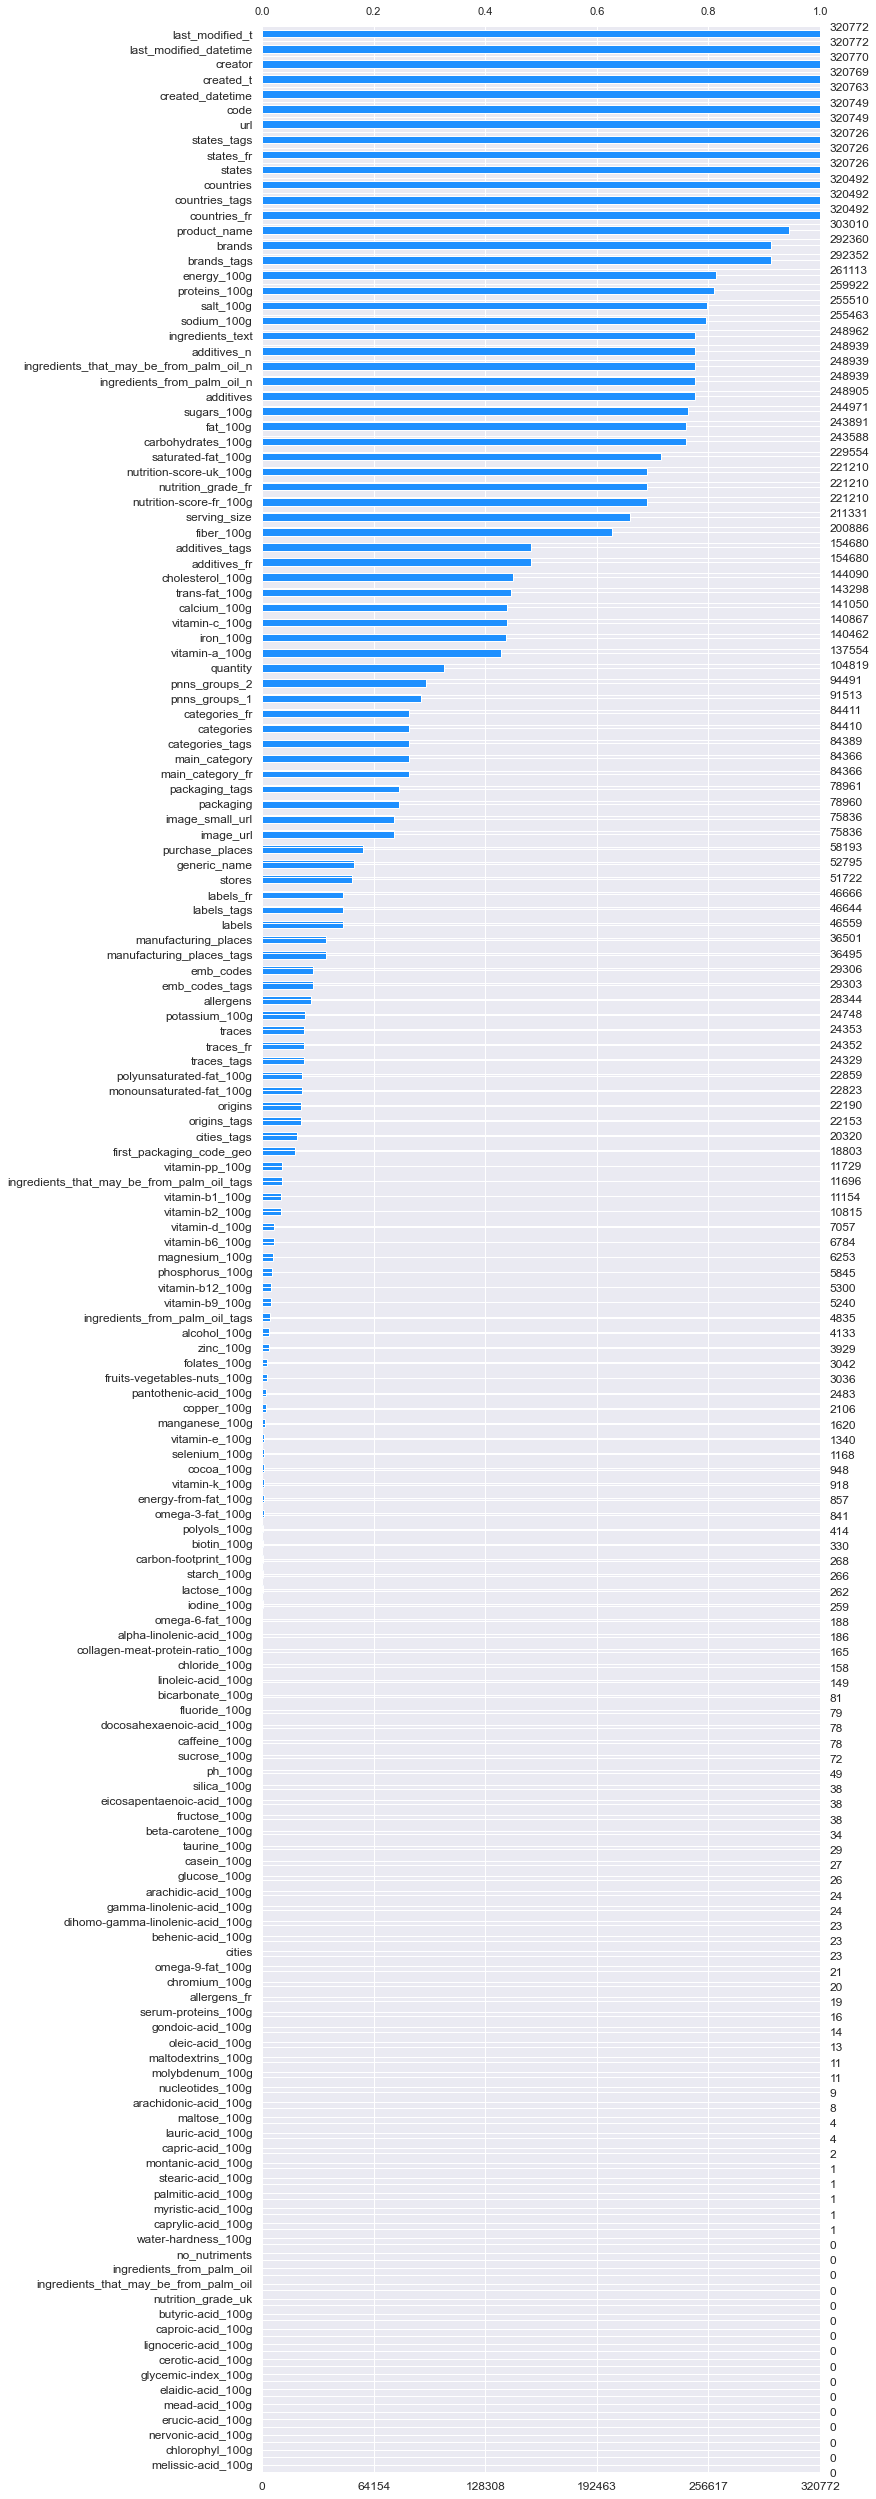

In [11]:
msno.bar(data,color="dodgerblue", sort="ascending", figsize=(10,45), fontsize=12)

## 1.3 Opérations de base sur les variables

In [12]:
# Renommage des variables
data.columns = data.columns.str.replace('-','_')
data = data.rename(columns={'nutrition-score-fr_100g':'nutriscore_100g'})

# Catégorisation des variables nominales
nominal_var = [
'categories',
'brands',
'packaging',
'labels',
'pnns_groups_1',
'pnns_groups_2',
'allergens',
'additives_tags',
'ingredients_from_palm_oil_tags',
'ingredients_that_may_be_from_palm_oil_tags',
'main_category']
for var in nominal_var:
    data[var] = data[var].astype('category')

# Catégorisation des variables ordinale
ordinal_var = ['nutrition_grade_fr']
for var in ordinal_var:
    data[var] = data[var].astype(CategoricalDtype(ordered=True))

In [13]:
percentage_features = {}
for column in data.columns:
        percentage_features[column]= round(data[column].isnull().sum()*100/data.shape[0])
percentage = pd.DataFrame.from_dict(percentage_features,orient='index').set_axis(['null_percentage'],axis=1)
percentage.sort_values(by='null_percentage',ascending=True)

,null_percentage
code,0
states_fr,0
states_tags,0
countries_fr,0
countries_tags,0
countries,0
states,0
created_t,0
last_modified_t,0
creator,0


**NOTE** : *Les pourcentages sont arrondis.*

<AxesSubplot:>

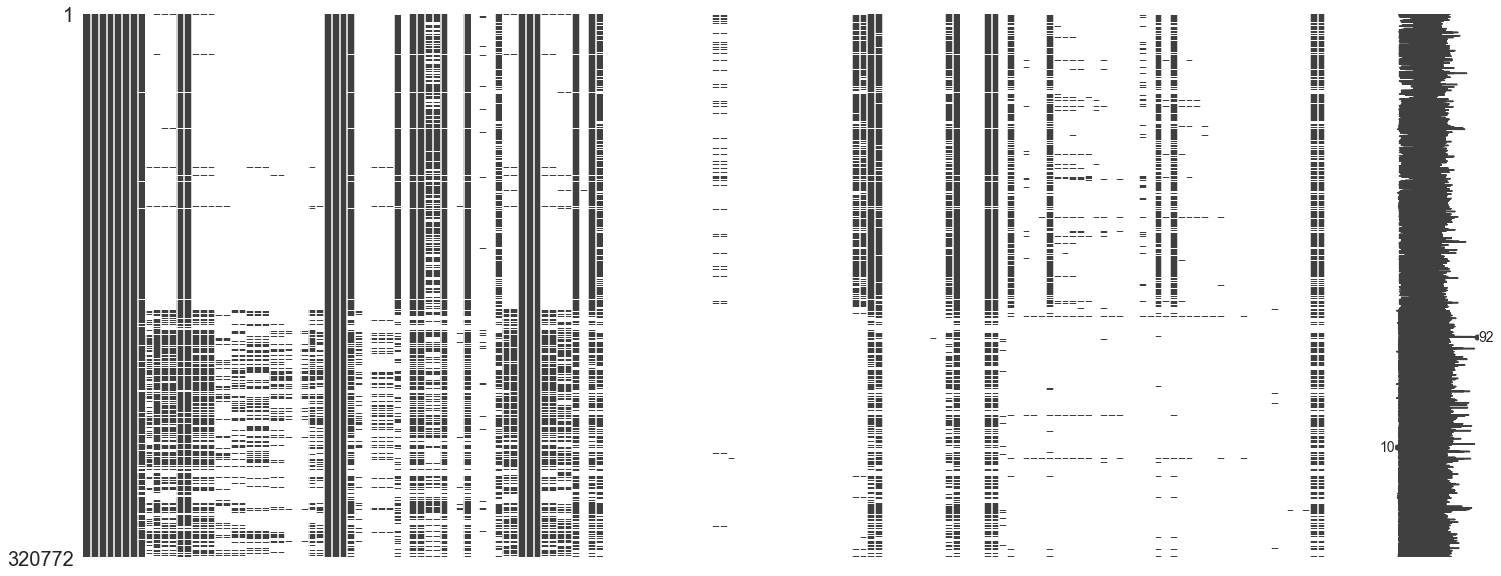

In [14]:
# État de santé du DataFrame
msno.matrix(data)

# 2. Retenir les données pertinentes

## 2.1 Transformer en DataFrame français

Comme c'est une organisation n'opérant qu'en France, il semble logique de ne garder que les données françaises.

In [15]:
# traiter les données du dataframe contenant les sous-catégories
def TraitementData(data):
    for col in data.columns:
            data[col] = data[col].astype(str).str.lower()
            data[col] = data[col].astype(str).str.replace(r'[-]', ' ', regex=True)
            data[col] = data[col].astype(str).str.replace('en:','')
            data[col] = data[col].astype(str).str.replace('fr:','')
            data[col] = data[col].astype(str).str.replace('de:','')
            data[col] = data[col].astype(str).str.replace('fi:','')
            data[col] = data[col].astype(str).str.replace('it:','')
            data[col] = data[col].astype(str).str.replace('pt:','')
            data[col] = data[col].astype(str).str.replace('ç','c')
            data[col] = data[col].astype(str).str.replace('œ','oe')
            data[col] = data[col].astype(str).str.replace('æ','ae')
            data[col] = data[col].astype(str).str.replace('ï','i')
            data[col] = data[col].astype(str).str.replace('î','i')
            data[col] = data[col].astype(str).str.replace('pomme de terre','patate')
            data[col] = data[col].astype(str).str.replace('pommes de terre','patate')
            data[col] = data[col].astype(str).str.title()
            

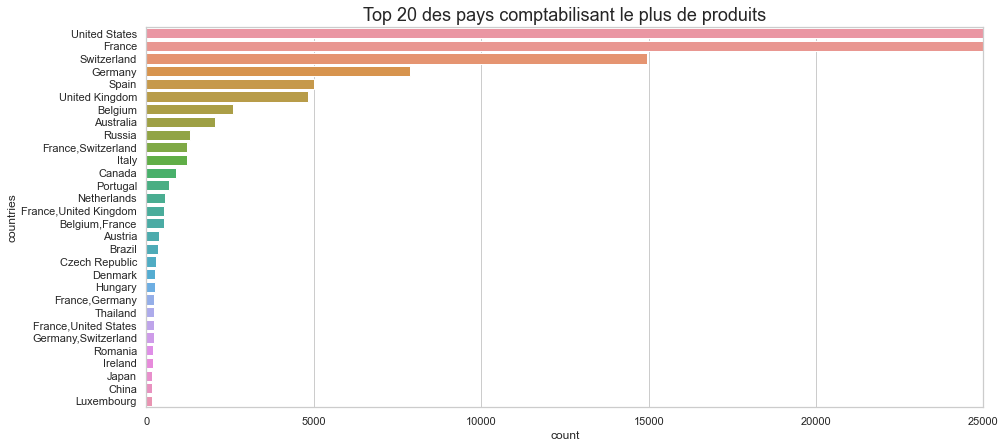

In [16]:
count_countries = pd.DataFrame.from_dict(data.groupby('countries_tags').count().sort_values(by='countries',ascending=False)['countries'].reset_index().set_axis(['countries','count'],axis=1)[0:30].to_dict(),orient='index').T
TraitementData(count_countries)
count_countries['count'] = count_countries['count'].astype('int')
sns.set(style="whitegrid")
plt.figure(figsize=(15,7))
plt.xlim(0,25000)
plt.title('Top 20 des pays comptabilisant le plus de produits', size=18)
plot = sns.barplot(data=count_countries, x='count', y='countries', orient='h')
plt.show()

In [17]:
# Liste des abreviations possibles de la France
abreviation_france = ['en:FR','FR','fr','france','France','FRANCE']
data_fr = data.copy()
for abrev in abreviation_france:
    data_fr.countries = data_fr.countries.str.replace(abrev, 'France')

In [18]:
# J'ai gardé les NaN au cas où ils soient présents en France, puis filtré les produits uniquement présents en France
data_fr.index = data_fr.countries
data_fr = data_fr[data_fr.index.str.contains('France', na=True)].reset_index(drop=True)
print('Le jeu de données est passé de {}'.format(data.shape[0]),'à {} lignes.'.format(data_fr.shape[0]))

Le jeu de données est passé de 320772 à 98447 lignes.


## 2.2 Variables retenues

In [19]:
features = [
'code',
'nutrition_grade_fr',
'nutrition_score_fr_100g',
'pnns_groups_2',
'pnns_groups_1',
'categories_fr',
'energy_100g',
'fat_100g',
'saturated_fat_100g',
'monounsaturated_fat_100g',
'polyunsaturated_fat_100g',
'omega_3_fat_100g',
'omega_6_fat_100g', 
'omega_9_fat_100g',
'trans_fat_100g',
'cholesterol_100g',
'carbohydrates_100g',
'sugars_100g',
'proteins_100g',
'sodium_100g',
'polyols_100g',
'fiber_100g',
'alcohol_100g'
]

**NOTE** : *Ces features selectionnées sont importantes pour le calcul de l'energie en kJ et le nutriscore mais n'apparaîtront pas dans l'analyse exploratoire.*

In [20]:
# Création d'un dataframe qui va récolter uniquement les variables ayant un taux supérieur à 55%
data_nan = data_fr.copy(deep=False)
# Suppression des colonnes contenant plus de 55 % de données manquantes
for column in data_nan.columns:
    if data_nan[column].isnull().sum()*100/data_nan.shape[0] >= 55:
        data_nan = data_nan.drop(column,axis=1)

In [21]:
# Au vu des intitulés, on peut considérer que les variables ci-dessous ne sont probablement pas dans la plupart des produits
important_but_empty = []
for feature in features:
    if feature not in data_nan.columns:
        important_but_empty.append(feature)
        print(feature)

monounsaturated_fat_100g
polyunsaturated_fat_100g
omega_3_fat_100g
omega_6_fat_100g
omega_9_fat_100g
trans_fat_100g
cholesterol_100g
polyols_100g
alcohol_100g


In [22]:
# Rajouter les variables importantes
data_nan[important_but_empty] = data_fr[important_but_empty]

In [23]:
# Associer dans un dictionnaire le taux de remplissage aux variables
percentage_features_2 = {}
for column in data_nan.columns:
    percentage_features_2[column]= round(data_nan[column].isnull().sum()*100/data_nan.shape[0])
    print(column)

code
url
creator
created_t
created_datetime
last_modified_t
last_modified_datetime
product_name
quantity
packaging
packaging_tags
brands
brands_tags
categories
categories_tags
categories_fr
countries
countries_tags
countries_fr
ingredients_text
additives_n
additives
ingredients_from_palm_oil_n
ingredients_that_may_be_from_palm_oil_n
nutrition_grade_fr
pnns_groups_1
pnns_groups_2
states
states_tags
states_fr
main_category
main_category_fr
image_url
image_small_url
energy_100g
fat_100g
saturated_fat_100g
carbohydrates_100g
sugars_100g
fiber_100g
proteins_100g
salt_100g
sodium_100g
nutrition_score_fr_100g
nutrition_score_uk_100g
monounsaturated_fat_100g
polyunsaturated_fat_100g
omega_3_fat_100g
omega_6_fat_100g
omega_9_fat_100g
trans_fat_100g
cholesterol_100g
polyols_100g
alcohol_100g


In [24]:
# Faire un dataframe présentant le taux de remplissage des variables avant et après sélection des produits français
percentage2 = pd.DataFrame.from_dict(percentage_features_2,orient='index').set_axis(['null_percentage'],axis=1)
percentage_final = percentage.merge(percentage2,left_index=True,right_index=True)
percentage_final['evolution'] = round((percentage_final['null_percentage_y']-percentage_final['null_percentage_x'])/percentage_final['null_percentage_x']*100).fillna(0).astype(int)

In [25]:
# Affichage
percentage_final.loc[features].sort_values(by='null_percentage_y',ascending=True)

,null_percentage_x,null_percentage_y,evolution
code,0,0,0
pnns_groups_2,71,32,-55
pnns_groups_1,71,34,-52
energy_100g,19,35,84
proteins_100g,19,35,84
categories_fr,74,37,-50
saturated_fat_100g,28,37,32
sodium_100g,20,37,85
sugars_100g,24,37,54
nutrition_grade_fr,31,38,23


**NOTE** : *On remarque un changement drastique du % de données manquantes pour chaque variable suite à la sélection de produits présents en France.*

## 2.2 Exclusion des colonnes trop vides

In [26]:
# Ajouter graphique visualisation avant apres
print('Le jeu de données est passé de {}'.format(data_fr.shape[1]),'à {} colonnes.'.format(data_nan.shape[1]))

Le jeu de données est passé de 162 à 54 colonnes.


**NOTE** : *Les variables numériques retenues dans l'analyse exploratoire ne sont vides que jusqu'à 54%.*

In [27]:
# Création d'un dataframe ayant les noms des produits en ligne et les features associées en colonne
df_useful_columns = data_nan.copy()
df_useful_columns.index = df_useful_columns.product_name
df_useful_columns = df_useful_columns[features]

In [28]:
# Vérifier si il restait des doublons
df_dupl = df_useful_columns.copy()
df_dupl['product_name'] = df_dupl.index
df_dupl.index = df_dupl['code']
print('il y a {} doublons.'.format(df_dupl[df_dupl.duplicated()].shape[0]))

il y a 0 doublons.


<AxesSubplot:>

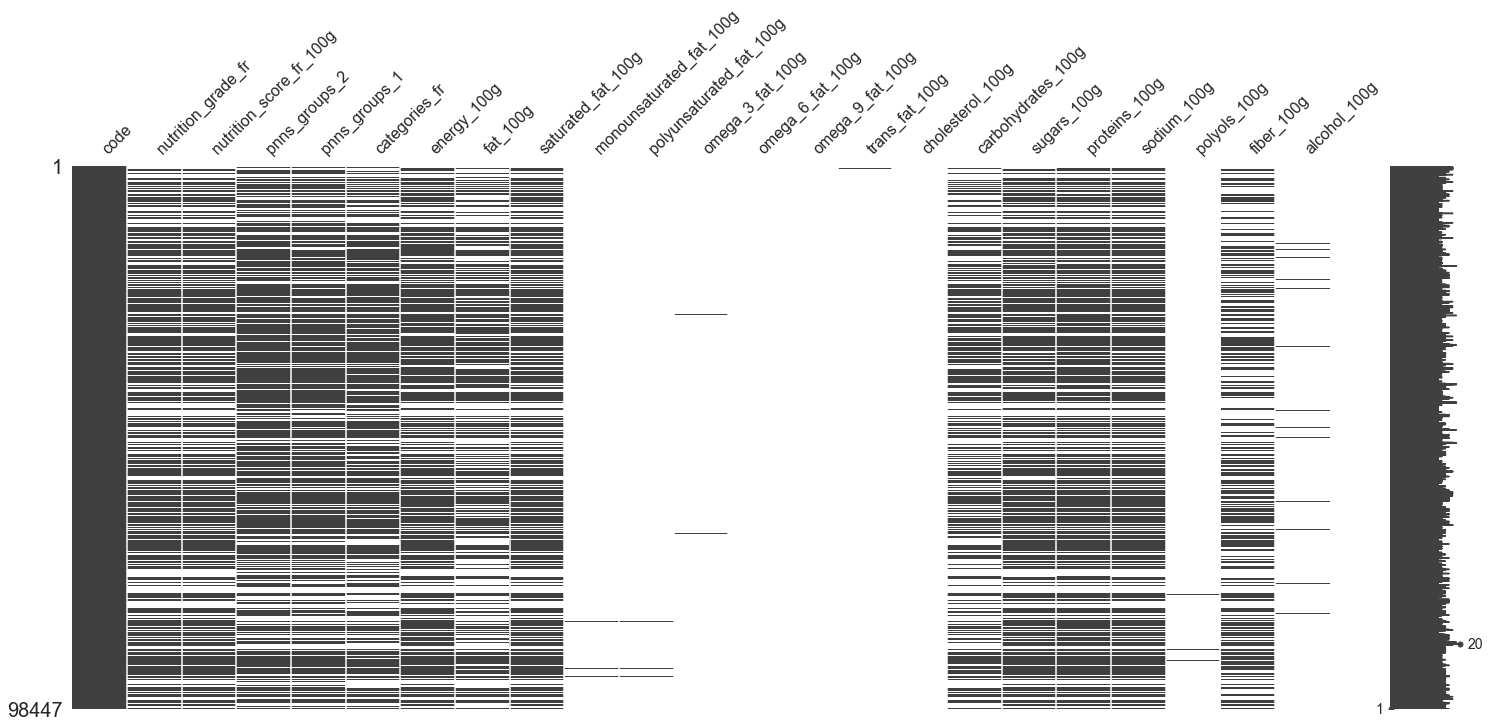

In [29]:
# Etat de santé du DataFrame
msno.matrix(df_useful_columns)

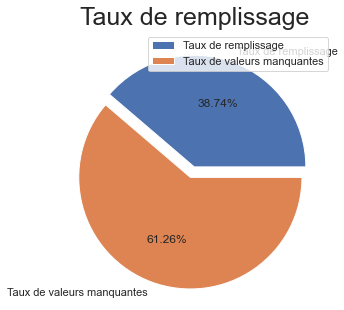

In [30]:
FillRate(df_useful_columns)

## 2.4 Sélection d'une méthode de catégorisation des produits

In [31]:
print('Il y a {} catégories dans ce tag.'.format(len(df_useful_columns['pnns_groups_1'].unique())))
df_useful_columns['pnns_groups_1'] = df_useful_columns['pnns_groups_1'].str.replace('cereals-and-potatoes','Cereals and potatoes')
df_useful_columns['pnns_groups_1'] = df_useful_columns['pnns_groups_1'].str.replace('sugary-snacks','Sugary snacks')
df_useful_columns['pnns_groups_1'] = df_useful_columns['pnns_groups_1'].str.replace('fruits-and-vegetables','Fruits and vegetables')
df_useful_columns['pnns_groups_1'].unique().tolist()

Il y a 14 catégories dans ce tag.


[nan,
 'unknown',
 'Cereals and potatoes',
 'Sugary snacks',
 'Beverages',
 'Fish Meat Eggs',
 'Composite foods',
 'Fruits and vegetables',
 'Milk and dairy products',
 'Salty snacks',
 'Fat and sauces']

In [32]:
print('Il y a {} catégories dans ce tag.'.format(len(df_useful_columns['pnns_groups_2'].unique())))
liste_categories = df_useful_columns['pnns_groups_2'].unique().tolist()
df_useful_columns['pnns_groups_2'] = df_useful_columns['pnns_groups_2'].str.title()
df_useful_columns['pnns_groups_2'] = df_useful_columns['pnns_groups_2'].str.replace('Legumes','Vegetables')
df_useful_columns['pnns_groups_2'].unique().tolist()

Il y a 42 catégories dans ce tag.


[nan,
 'Unknown',
 'Vegetables',
 'Biscuits And Cakes',
 'Sweets',
 'Non-Sugared Beverages',
 'Sweetened Beverages',
 'Meat',
 'One-Dish Meals',
 'Soups',
 'Chocolate Products',
 'Alcoholic Beverages',
 'Sandwich',
 'Cheese',
 'Appetizers',
 'Dressings And Sauces',
 'Dried Fruits',
 'Nuts',
 'Breakfast Cereals',
 'Pizza Pies And Quiche',
 'Fruits',
 'Fruit Juices',
 'Fats',
 'Cereals',
 'Bread',
 'Processed Meat',
 'Ice Cream',
 'Fish And Seafood',
 'Pastries',
 'Milk And Yogurt',
 'Dairy Desserts',
 'Tripe Dishes',
 'Artificially Sweetened Beverages',
 'Fruit Nectars',
 'Potatoes',
 'Eggs',
 'Salty And Fatty Products']

In [33]:
# Taux de remplissage selon chaque méthode de catégorisation
df_test_fillrate = df_useful_columns[['categories_fr','pnns_groups_1','pnns_groups_2']]
for col in df_test_fillrate.columns:
    print('Nombre de valeurs dans', col,' : {}.'.format(df_test_fillrate[col].count().sum()))
print('Nombre de valeurs dans les 3 tags réunis : {}.'.format(df_test_fillrate.dropna(how='all').shape[0]))
print()
print("Le delta n'est pas significatif. Nous pouvons nous concentrer sur les 2 types de groupes PNNS car ils permettent \nd'agglomérer les produits dans des clusters de différente taille.")

# Supprimer les tags inutiles
df_cat_final = df_useful_columns.drop(columns=['categories_fr'])

Nombre de valeurs dans categories_fr  : 61830.
Nombre de valeurs dans pnns_groups_1  : 64763.
Nombre de valeurs dans pnns_groups_2  : 66926.
Nombre de valeurs dans les 3 tags réunis : 66949.

Le delta n'est pas significatif. Nous pouvons nous concentrer sur les 2 types de groupes PNNS car ils permettent 
d'agglomérer les produits dans des clusters de différente taille.


**NOTE** : *Il était également possible de faire un traitement des strings dans la variable categories_fr. Non-pertinent à mon sens car il s'agit de la variable catégorielle la moins remplie, et le travail à fournir pour créer ces nouvelles catégories n'apporterait aucune plus-value par rapport aux catégories existantes.*

In [34]:
# Uniformiser les valeur vides
def MajNan(data):
    for col in data.columns:
        data[col] = data[col].replace('nan',np.NaN)
        data[col] = data[col].replace('NaN',np.NaN)
        data[col] = data[col].replace('none',np.NaN)
        data[col] = data[col].replace('None',np.NaN)
        data[col] = data[col].replace('unknown',np.NaN)
        data[col] = data[col].replace('Unknown',np.NaN)
        

MajNan(df_cat_final)

<AxesSubplot:>

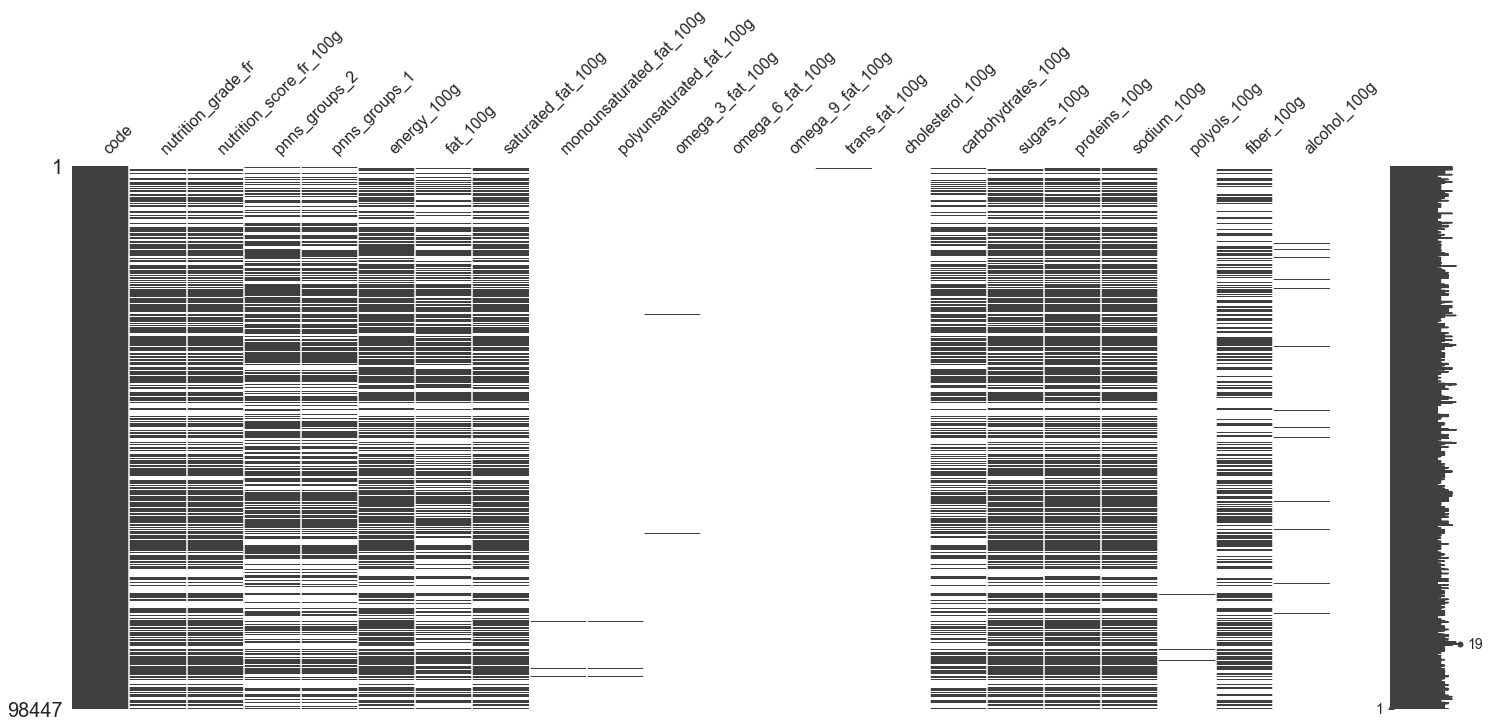

In [35]:
# Etat de santé du DataFrame
msno.matrix(df_cat_final)

# 3. Traitement des valeurs aberrantes

In [36]:
# Catégorie de variables génériques
main = [
'code',
'nutrition_grade_fr',
'nutrition_score_fr_100g',
'energy_100g',
'pnns_groups_2',
'pnns_groups_1'
]

In [37]:
# Catégorie de variables à valeur nutritionnelle + le code pour éliminer les doublons
_100g_code = [
'code',
'fat_100g',
'saturated_fat_100g',
'monounsaturated_fat_100g',
'polyunsaturated_fat_100g',
'omega_3_fat_100g',
'omega_6_fat_100g', 
'omega_9_fat_100g',
'trans_fat_100g',
'cholesterol_100g',
'carbohydrates_100g',
'sugars_100g',
'proteins_100g',
'sodium_100g',
'polyols_100g',
'fiber_100g',
'alcohol_100g'
]

In [38]:
# Catégorie de variables à valeur nutritionnelle
_100g = [
'fat_100g',
'saturated_fat_100g',
'monounsaturated_fat_100g',
'polyunsaturated_fat_100g',
'omega_3_fat_100g',
'omega_6_fat_100g', 
'omega_9_fat_100g',
'trans_fat_100g',
'cholesterol_100g',
'carbohydrates_100g',
'sugars_100g',
'proteins_100g',
'sodium_100g',
'polyols_100g',
'fiber_100g',
'alcohol_100g'
]

In [39]:
features_final = [
'code',
'nutrition_grade_fr',
'nutrition_score_fr_100g',
'energy_100g',
'pnns_groups_2',
'pnns_groups_1',
'fat_100g',
'saturated_fat_100g',
'monounsaturated_fat_100g',
'polyunsaturated_fat_100g',
'omega_3_fat_100g',
'omega_6_fat_100g', 
'omega_9_fat_100g',
'trans_fat_100g',
'cholesterol_100g',
'carbohydrates_100g',
'sugars_100g',
'proteins_100g',
'sodium_100g',
'polyols_100g',
'fiber_100g',
'alcohol_100g'
]

In [40]:
total_per_100g = [
'fat_100g',
'carbohydrates_100g',
'proteins_100g']

**NOTE** : *Ces différentes listes vont me permettre de regrouper les variables pour faciliter les traitements.*

## 3.1 Définition de catégories de variables

In [41]:
var_aberants = []
for col in _100g:
    if df_cat_final[df_cat_final[col] > 100].shape[0] > 0:
        var_aberants.append(col)
var_aberants

['fat_100g',
 'saturated_fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g']

In [42]:
#On initialise l'écart-type et la médiane
sigma = [0 for _ in range(len(var_aberants))]
median = [0 for _ in range(len(var_aberants))]
#Puis on complètes les valeurs avec le dataset sans les valeurs nulles
for i in range(len(var_aberants)):
    median[i] = df_cat_final[pd.notnull(df_cat_final[var_aberants[i]])][var_aberants[i]].median()
    serie = df_cat_final[pd.notnull(df_cat_final[var_aberants[i]])][var_aberants[i]]
    serie = serie.sort_values()
    sigma[i] = np.std(serie[:-25])

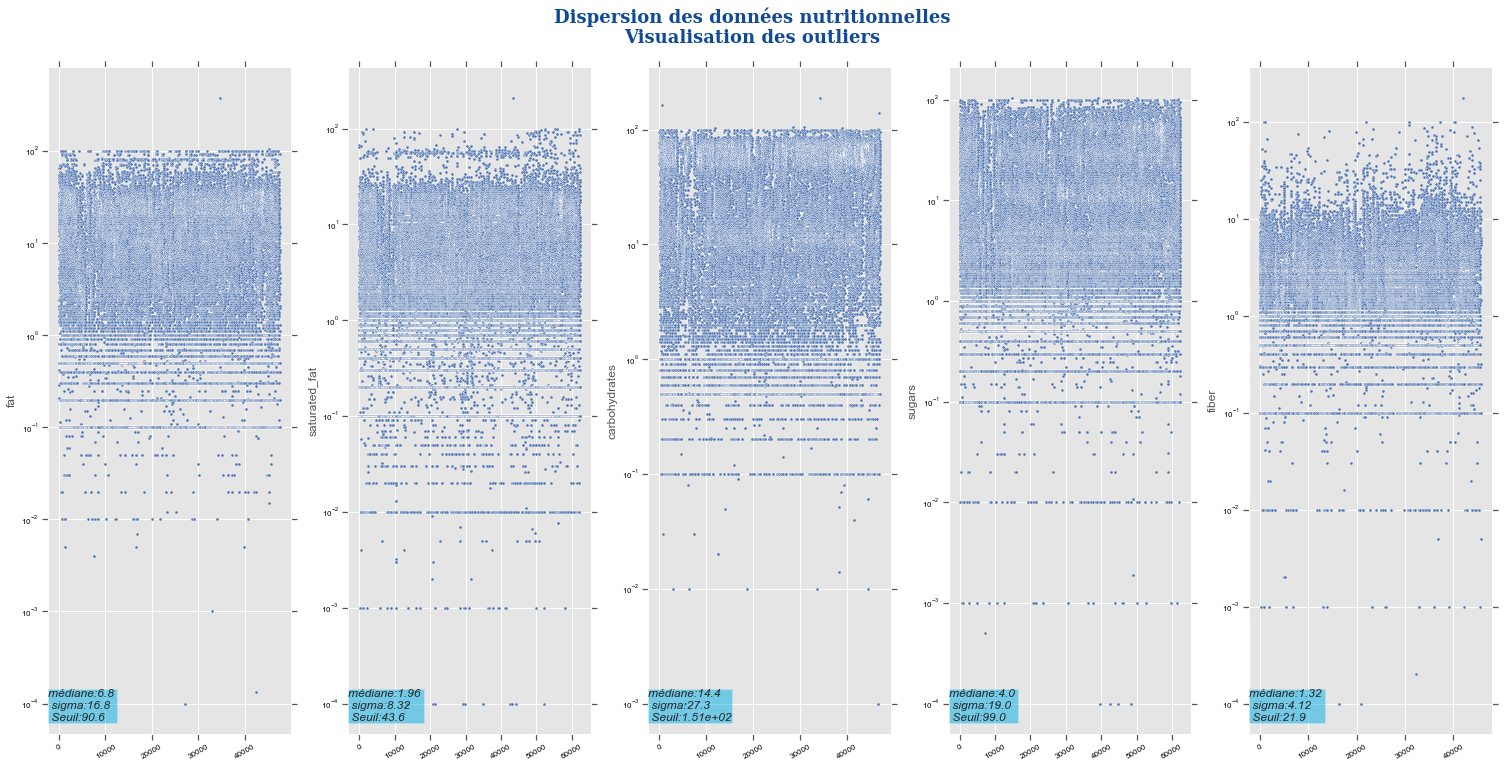

In [43]:
plt.style.use('ggplot')
tPlot, axes = plt.subplots(nrows=1, ncols=5, sharex=False, sharey=False, figsize=(21,10))
axes = np.array(axes)

font_title = {'family': 'serif',
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18}

i=0
for ax in axes.reshape(-1):
    colonne = var_aberants[i]
    test = df_cat_final[pd.notnull(df_cat_final[colonne])][colonne]
    ax.tick_params(labelcolor='black',top='off',bottom='on',left='on',right='off',labelsize=8)
    ax.set_ylabel(colonne.rstrip("_100g"), fontsize = 12)
    ax.set_yscale("log")
    ax.plot(list(test), 'b.', markeredgewidth = 0.3, markeredgecolor='w')
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
    ax.text(0., 0.02, 'médiane:{:.3} \n sigma:{:.3} \n Seuil:{:.3}'.format(median[i], sigma[i], (median[i] + 5*sigma[i])),
            style='italic', transform=ax.transAxes, fontsize = 12,
            bbox={'facecolor':'#00afe6', 'alpha':0.5, 'pad':0})
    i += 1

tPlot.text(0.5, 1.01, r"Dispersion des données nutritionnelles" "\n" "Visualisation des outliers", ha='center', fontdict=font_title)
plt.tight_layout()

**NOTE** : *En ce qui concerne les valeurs aberrantes, elles apparaissent clairement ici.*

## 3.2 Valeurs supérieures à 100 pour chaque colonne

In [44]:
# Nouveau DataFrame à chaque traitement d'aberration 
df_inf_100 = df_cat_final.copy()
df_inf_100 = df_inf_100.reset_index()

aberrant_features = []
for col in _100g:
    if df_inf_100[df_inf_100[col] > 100].shape[0] != 0:
        aberrant_features.append(col)
        
for feature in aberrant_features:
    for loc in df_inf_100.index:
        if df_inf_100[feature][loc] > 100:
            df_inf_100[feature][loc] = np.nan
df_inf_100.index = df_inf_100.product_name
df_inf_100 = df_inf_100.drop(['product_name'],axis=1)

**NOTE** : *Nous remplaçons ici les valeurs nutritionnelles supérieures à 100 par un NaN afin de l'imputer plus tard.*

In [45]:
# Vérification du nombre de valeurs abérrantes pour les variables nutritionnelles
for col in _100g:
    print(col,":",df_inf_100[df_inf_100[col] > 100].shape[0])

fat_100g : 0
saturated_fat_100g : 0
monounsaturated_fat_100g : 0
polyunsaturated_fat_100g : 0
omega_3_fat_100g : 0
omega_6_fat_100g : 0
omega_9_fat_100g : 0
trans_fat_100g : 0
cholesterol_100g : 0
carbohydrates_100g : 0
sugars_100g : 0
proteins_100g : 0
sodium_100g : 0
polyols_100g : 0
fiber_100g : 0
alcohol_100g : 0


<AxesSubplot:>

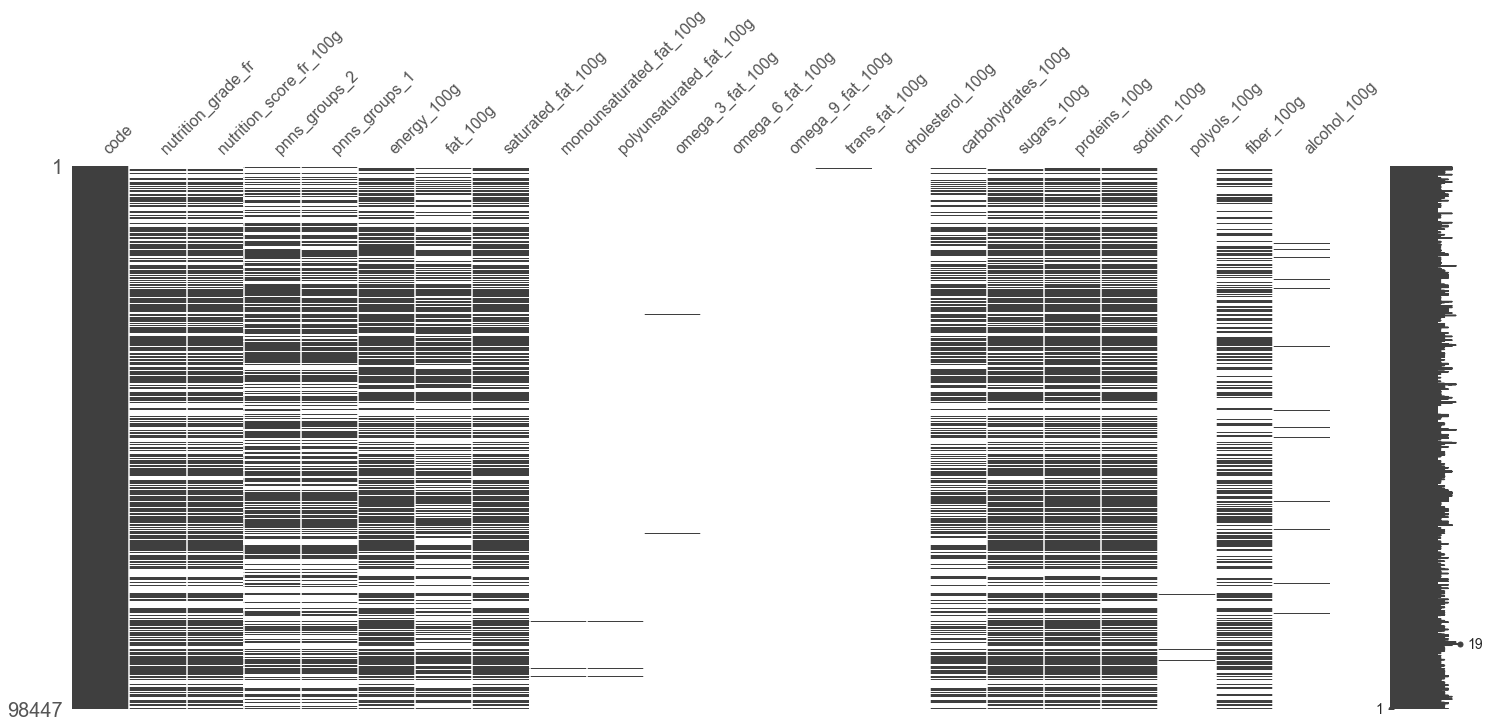

In [46]:
# Etat de santé du DataFrame
msno.matrix(df_inf_100)

## 3.3 Somme supérieure à 100 pour les macronutriments

In [47]:
# On considère qu'au dessus de 110, il ne peut plus s'agir d'erreurs d'approximation
df_macro = df_inf_100[_100g_code].copy()
df_macro['total_per_100g'] = df_macro[total_per_100g].sum(axis=1)
df_macro = df_macro[df_macro['total_per_100g'] > 110]
aberant_values_2 = df_macro.code.tolist()
df_macro_2 = df_inf_100[~df_inf_100['code'].isin(aberant_values_2)]

**NOTE** : *Une fois la détection des valeurs abérrantes faite et sans analyse de type métier, il est impossible de définir quelles valeurs imputer ou non. En contexte d'entreprise, ces abérrations feraient l'objet d'une analyse spécifique avec les métiers. ici nous allons directement supprimer les produits ayant une somme des macronutriments supérieure à 110.*

In [48]:
# Nombre de valeurs abérrantes pour les macronutriments
df_macro_2['total_per_100g'] = df_macro_2[total_per_100g].sum(axis=1)
print('total_per_100g :',df_macro_2[df_macro_2['total_per_100g'] > 110].shape[0])
df_macro_2 = df_macro_2.drop(['total_per_100g'],axis=1)

total_per_100g : 0


In [49]:
print('Le jeu de données est passé de {}'.format(df_inf_100.shape[0]),'à {} lignes.'.format(df_macro_2.shape[0]))

Le jeu de données est passé de 98447 à 98438 lignes.


<AxesSubplot:>

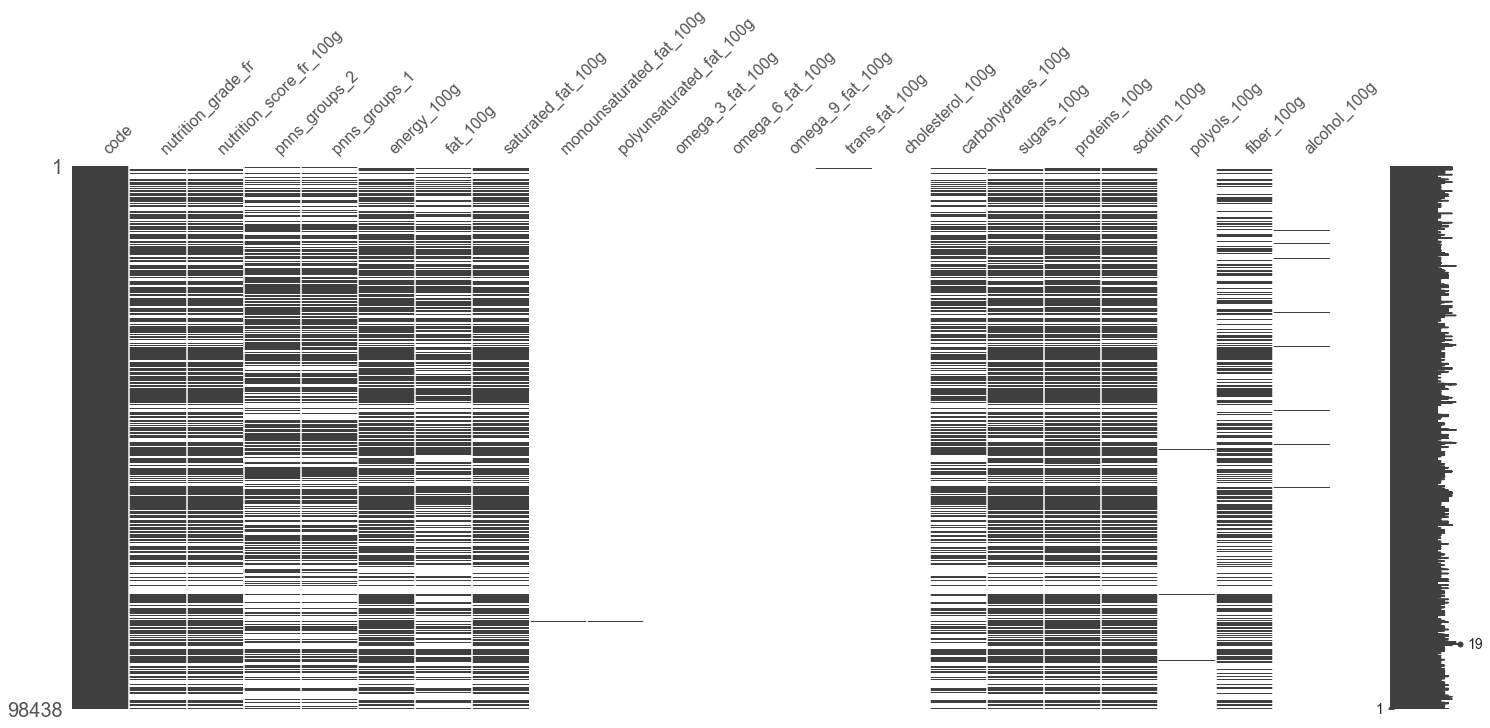

In [50]:
# Etat de santé du DataFrame
msno.matrix(df_macro_2)

## 3.4 Somme des valeurs nutritionnelle égale à 0.

In [51]:
# Supprimer les produits dont la somme des valeurs nutritionnelle est nulle
aberant_values_3 = df_macro_2[(df_macro_2[_100g].sum(axis=1) == 0) & (~df_macro_2['pnns_groups_2'].isna())].code.tolist()
df_sup_0 = df_macro_2[~df_macro_2['code'].isin(aberant_values_3)]

**NOTE** : *On considère que les produits ayant une somme des valeurs nutritionnelles inférieure ou égale à 0 n'ont pas assez de données pertinentes pour être intégrées à l'analyse exploratoire et seront donc supprimés. Pour les produits ayant une somme des macronutriments égale à 0 mais des valeurs nutritionnelles remplies, elles pourront être imputées plus tard par un KNN.*

In [52]:
print('Le jeu de données est passé de {}'.format(df_macro_2.shape[0]),'à {} lignes.'.format(df_sup_0.shape[0]))

Le jeu de données est passé de 98438 à 88540 lignes.


<AxesSubplot:>

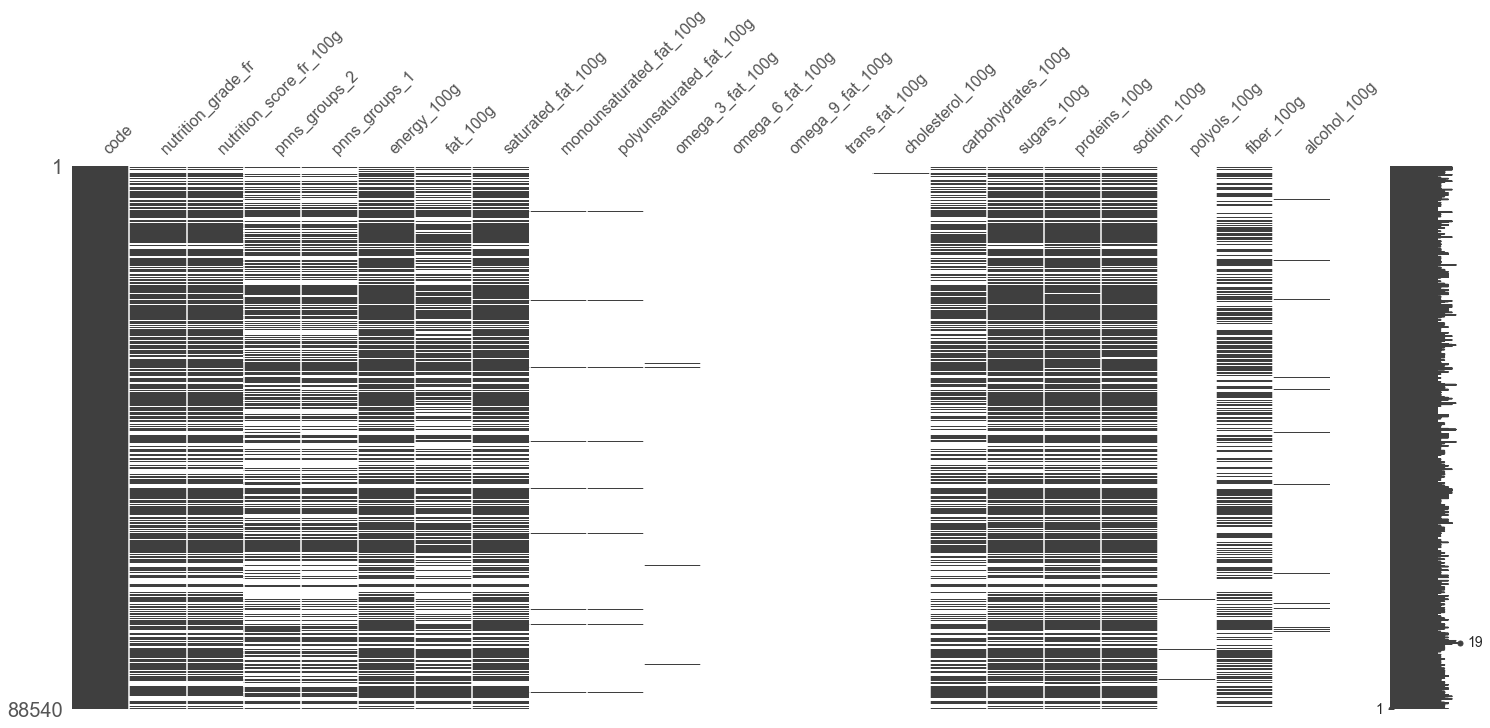

In [53]:
# Etat de santé du DataFrame
msno.matrix(df_sup_0)

# 4. Imputation de données

## 4.1 Méthode 1 : Remplacer par 0

In [54]:
# Imputer par 0 les colonnes vides à au moins 97%
df_0 = df_sup_0.copy()
print('Pourcentage de données manquantes par colonne:\n')
for feature in features_final:
    if df_0[feature].isnull().sum()*100/df_0.shape[0] > 97:
        df_0.fillna(value={feature:0},inplace=True)
    print(feature,':', round(df_0[feature].isnull().sum()*100/df_0.shape[0]))

Pourcentage de données manquantes par colonne:

code : 0
nutrition_grade_fr : 31
nutrition_score_fr_100g : 31
energy_100g : 27
pnns_groups_2 : 50
pnns_groups_1 : 52
fat_100g : 46
saturated_fat_100g : 30
monounsaturated_fat_100g : 0
polyunsaturated_fat_100g : 0
omega_3_fat_100g : 0
omega_6_fat_100g : 0
omega_9_fat_100g : 0
trans_fat_100g : 0
cholesterol_100g : 0
carbohydrates_100g : 47
sugars_100g : 30
proteins_100g : 28
sodium_100g : 30
polyols_100g : 0
fiber_100g : 49
alcohol_100g : 0


**NOTE** : *Les variables vides à plus de 97% sont des valeurs nutritionnelles peu présentes dans les produits et donc supprimables. Ce sont les mêmes qui ne seront pas conservées pour l'analyse exploratoire.*

<AxesSubplot:>

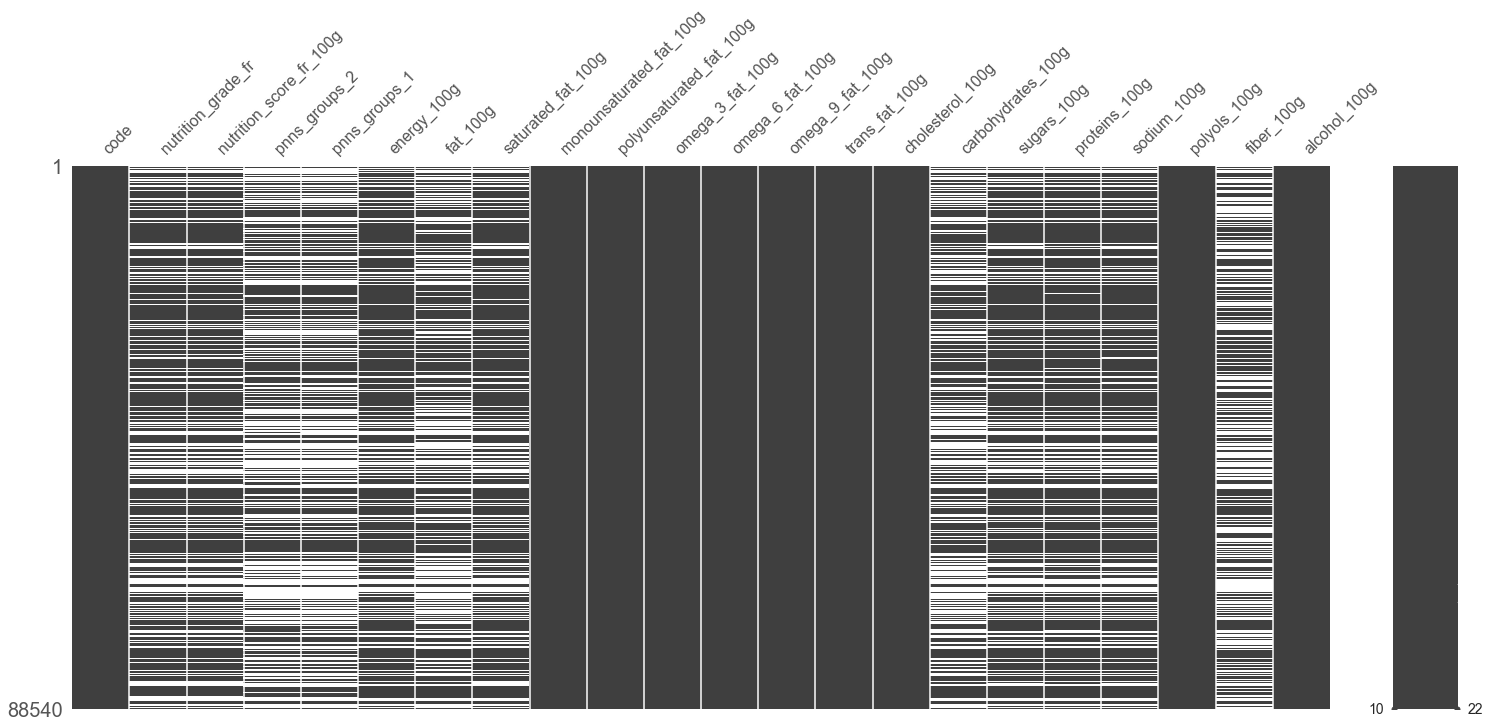

In [55]:
# Etat de santé du DataFrame
msno.matrix(df_0)

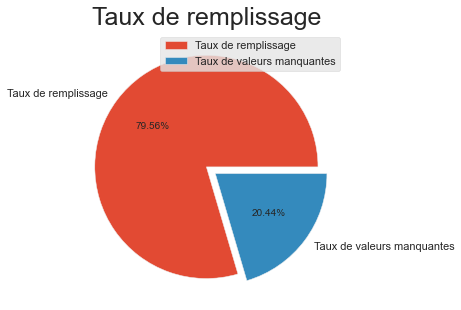

In [56]:
FillRate(df_0)

## 4.4 Méthode 2 : Imputer les calories au-delà du seuil possible

In [57]:
# Produit dépassant le seuil possible de calories kJ pour 100g
df_cal = df_0.copy()
df_cal = df_cal.reset_index()
for loc in df_cal.index:
    if df_cal.energy_100g[loc] > 3767.4:
        df_cal['energy_100g'][loc] = np.nan
df_cal.index = df_cal.product_name
df_cal = df_cal.drop(['product_name'],axis=1)

In [58]:
df_cal['total_per_100g'] = df_cal[total_per_100g].sum(axis=1)
df_cal = df_cal.reset_index()
aberrant_cal = df_cal[(df_cal.energy_100g == 0) & (df_cal.total_per_100g != 0)].index.tolist()

In [59]:
for index in aberrant_cal:
    df_cal.energy_100g[index] = np.nan

**NOTE** : *Pour estimer le seuil maximum d'énergie possible pour 100g d'aliments, il suffit de convertir 100g de gras en calories, ce qui donne 9 kcal * 100 grammes <=> 3767,4 kJoules.*

In [60]:
# Remplir les valeurs nulles par le calcul 
def ImputeEnergy(data):
    
    energy_exception =['polyols_100g','fiber_100g', 'alcohol_100g']

    if data[energy_exception].any in list(data.columns):
        data['energy_100g'].fillna(data['fat_100g']*37.76 + data['carbohydrates_100g']*16.744 + data['proteins_100g']*16.744 + data['alcohol_100g']*29.300\
                                 + data['fiber_100g']*8.370+ data['polyols_100g']*1.040, inplace=True)
    else :
        data['energy_100g'].fillna(data['fat_100g']*37.674 + data['carbohydrates_100g']*16.744 + data['proteins_100g']*16.744 , inplace=True)
        
    return data

df_cal_2 = ImputeEnergy(df_cal)

In [61]:
# Nombre de valeurs abérrantes pour energy_100g
print('Nombre de valeurs supérieure au seuil :',df_cal_2[df_cal_2.energy_100g > 3767.4].shape[0])
print('Nombre de valeurs abérantes :',df_cal_2[(df_cal_2.energy_100g == 0) & (df_cal_2.total_per_100g != 0)].shape[0])

Nombre de valeurs supérieure au seuil : 0
Nombre de valeurs abérantes : 0


**NOTE** : *Le calcul de l'énergie tel que calculé ici a ses limites. En effet il manque beaucoup de données et de ce fait les imputations peuvent conduire à des approximations répétées voir des imputations sur des valeurs inexistantes en réalité.*

<AxesSubplot:>

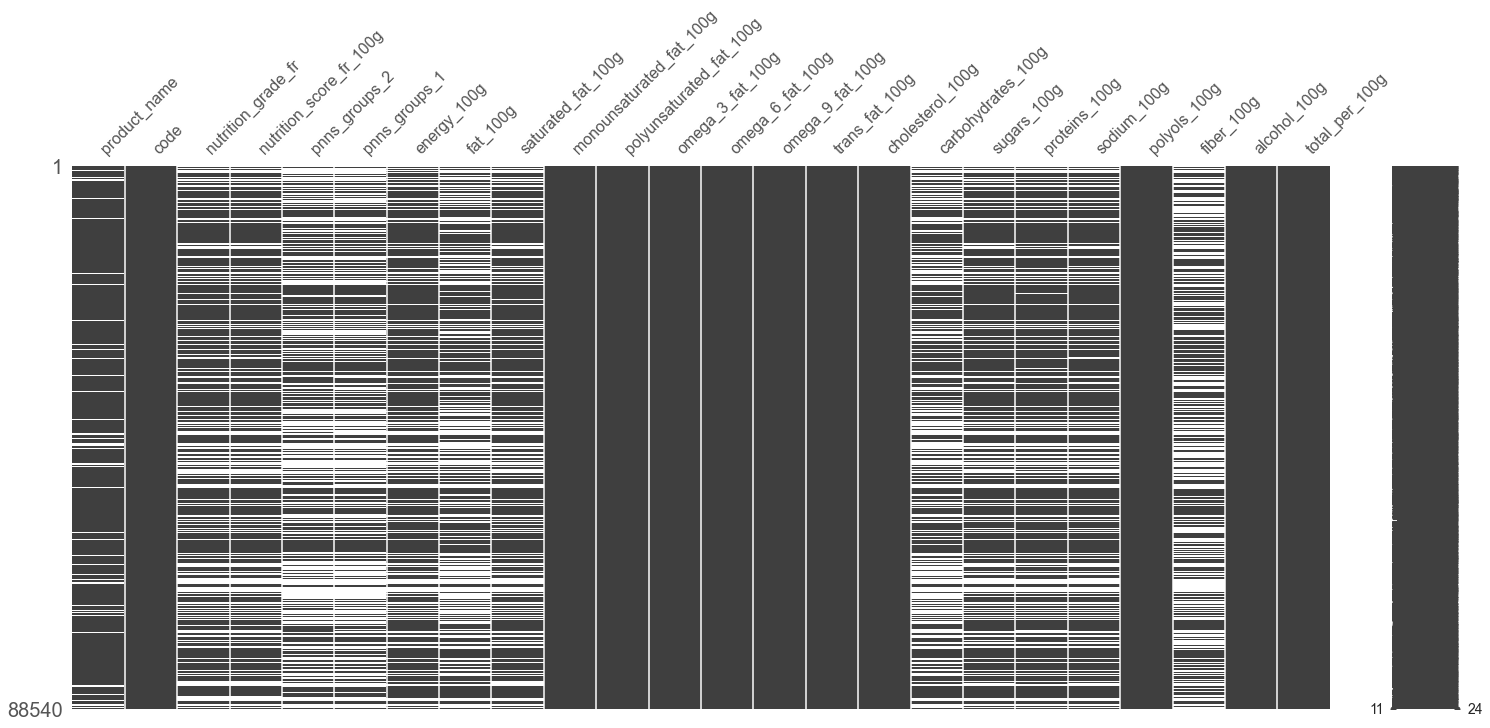

In [62]:
# Etat de santé du DataFrame
msno.matrix(df_cal_2)

## 4.5 Méthode 3 : Calcul du nutriscore

In [63]:
df_nutri = df_cal_2.copy()

In [64]:
high_rate_fruit = ['fruit juices','dried fruits','legumes','vegetables','fruits', 'soups','potatoes','fruit nectars']

medium_rate_fruit = ['unknown', 'sweetened beverages', 'dressings and sauces', 'ice cream', 'pastries', 'dairy desserts',
                     'pizza pies and quiche', 'pizza pies and quiches']

low_rate_fruit = ['waters and flavored waters','chocolate products', 'fish and seafood', 'salty and fatty products', 
                  'cheese', 'cereals', 'appetizers', 'one dish meals', 'bread', 'fats', 'plant based milk substitutes',
                  'alcoholic beverages', 'processed meat', 'breakfast cereals', 'meat', 'eggs', 'sandwiches',
                  'offals', 'teas and herbal teas and coffees', 'biscuits and cakes', 'sweets', 'milk and yogurt',
                  'artificially sweetened beverages', 'unsweetened beverages','nuts']

**NOTE** : *Pour que le calcul du nutriscore soit complet, il manque la proportion en fruits et légumes de chaque produits. Nous allons approximer cette proportion en fonction de la catégorie à laquelle le produit appartient.*

In [65]:
# Définir une nouvelle variable de proportion de fruits et légumes
df_nutri['fruits_vegetables_rate_100g'] = [81 if cat in high_rate_fruit else 45 if cat in medium_rate_fruit else 25 for cat in df_nutri.pnns_groups_2]

In [66]:
def CalculNutriScore(row):
    #Energy
    if row["energy_100g"] <= 335:
        a = 0
    elif ((row["energy_100g"] > 335) & (row["energy_100g"] <= 1675)):
        a = 5
    else:
        a = 10 
    #Sugar
    if row["sugars_100g"] <= 4.5:
        b = 0
    elif ((row["sugars_100g"] > 4.5) & (row["sugars_100g"] <= 22.5)):
        b = 5
    else:
        b = 10
    #saturated-fat
    if row["saturated_fat_100g"] <= 1:
        c = 0
    elif ((row["saturated_fat_100g"] > 1) & (row["saturated_fat_100g"] <= 5)):
        c = 5
    else:
        c = 10
    #sodium
    if (row["sodium_100g"]/1000) <= 90:
        d = 0
    elif (((row["sodium_100g"]/1000) > 90) & ((row["sodium_100g"]/1000) <= 450)):
        d = 5
    else:
        d = 10
    #fruits-vegetables-rate
    if row["fruits_vegetables_rate_100g"] <= 40:
        e = 0
    elif ((row["fruits_vegetables_rate_100g"] > 40) & (row["fruits_vegetables_rate_100g"] <= 80)):
        e = -2
    else:
        e = -5
    #fiber
    if row["fiber_100g"] <= 0.7:
        f = 0
    elif ((row["fiber_100g"] > 0.7) & (row["fiber_100g"] <= 3.5)):
        f = -2
    else:
        f = -5
    #proteins
    if row["proteins_100g"] <= 1.6:
        g = 0
    elif ((row["proteins_100g"] > 1.6) & (row["proteins_100g"] <= 8)):
        g = -2
    else:
        g = -5
    
    #Global_score
    global_score = a+b+c+d+e+f+g
    
    return global_score

**NOTE** : *L'attribution du score à été trouvé sur Kaggle. Voici le lien : https://www.kaggle.com/code/michaelfumery/openfoodfacts-data-cleaning/notebook*

In [67]:
#Nutriscore
def CalculNutriGrade(row):
    if row["CalculNutriScore"] < 0 :
        nutriscore = "a"
    elif ((row["CalculNutriScore"] >= 0) & (row["CalculNutriScore"] < 5)) :
        nutriscore = "b"
    elif ((row["CalculNutriScore"] >= 5) & (row["CalculNutriScore"] < 10)) :
        nutriscore = "c"
    elif ((row["CalculNutriScore"] >= 10) & (row["CalculNutriScore"] < 20)) :
        nutriscore = "d"
    else:
        nutriscore = "e"
        
    return nutriscore

In [68]:
# Appliquer au df_nutri le nutriscore
df_nutri["CalculNutriScore"] = df_nutri.apply(lambda row: CalculNutriScore(row),axis=1)
df_nutri["CalculNutriGrade"] = df_nutri.apply(lambda row: CalculNutriGrade(row),axis=1)

**NOTE** : *Nous devons à présent vérifier les erreurs d'imputation sur les scores déjà connus, ce qui nous permettra de voir si les calculs sont satisfaisants et utilisables.*

In [69]:
df_scores = df_nutri[['nutrition_grade_fr', 'nutrition_score_fr_100g', 'CalculNutriGrade', 'CalculNutriScore']][df_nutri['CalculNutriScore'].isnull()==False].dropna()
accuracy_nutrigrade = accuracy_score(df_scores['nutrition_grade_fr'].values, df_scores['CalculNutriGrade'].values)
print("L'accuracy_score sur les Nutrigrades calculés est de : {:.2f} %.".format(accuracy_nutrigrade*100))

L'accuracy_score sur les Nutrigrades calculés est de : 46.27 %.


**NOTE** : *On peut considérer que le calcul du nutriscore manque trop de précision. Également, cette imputation n'ajouterais au DataFrame final que 5% de données justes supplémentaires, ce qui est dérisoire.*

## 4.2 Méthode 4 : Imputer par la médiane avec un KNN

In [70]:
df_KNN = df_cal_2.copy()

In [71]:
# Lister les produits ayant une catégorie
df_KNN = df_KNN.reset_index()
df_KNN.index = df_KNN.code
liste_prod_w_cat = df_KNN.pnns_groups_2.dropna().index.tolist()

# Supprimer les produits sans catégories
df_KNN_2 = df_KNN[df_KNN.index.isin(liste_prod_w_cat)]
df_KNN_2.index = df_KNN_2.product_name
df_KNN_2 = df_KNN_2.drop(['product_name'],axis=1)

In [75]:
# Importer dans une liste les variables à imputer
KNN_features = []
for feature in df_cal_2.columns:
    if df_cal_2[feature].isna().sum() != 0:
        if feature in _100g:
            KNN_features.append(feature)

# Importer dans une liste les variables non imputées qui serviront lors de la concaténation finale
remained_features = []
for feature in features_final:
    if feature not in KNN_features:
        remained_features.append(feature)

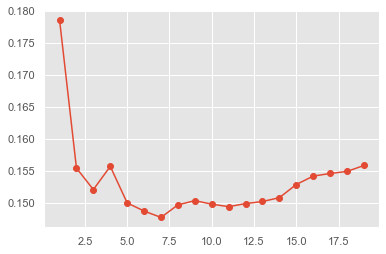

In [84]:
# Permet d'avoir un K optimal (égal à 3)
_100g.remove('sugars_100g')
df_KNN_2_test = df_KNN_2.dropna()
xtrain, xtest, ytrain, ytest = train_test_split(df_KNN_2_test[_100g],df_KNN_2_test['sugars_100g'], train_size=0.8)
errors = []
K = [n for n in np.arange(1,20,1)]
for k in K:
    model = neighbors.KNeighborsRegressor(n_neighbors=k)
    model.fit(xtrain, ytrain)
    errors.append(1 - model.score(xtest, ytest))
_100g.append('sugars_100g')
plt.plot(K, errors, 'o-')
plt.show()

In [85]:
imputer = KNNImputer(missing_values=np.nan, n_neighbors=7,weights='distance')
X = df_KNN_2[KNN_features]
df_KNN_3 = pd.DataFrame(imputer.fit_transform(X),index = df_KNN_2.index, columns = X.columns)

In [86]:
# Concat l'imputation de données par mediane et catégorie
frames = [df_KNN_2[remained_features],df_KNN_3]
df_KNN_4 = pd.concat(frames,axis=1)

In [87]:
# On considère qu'au dessus de 110, il ne peut plus s'agir d'erreurs d'approximation
df_macro_3 = df_KNN_4[_100g_code].copy()
df_macro_3['total_per_100g'] = df_macro_3[total_per_100g].sum(axis=1)
df_macro_3 = df_macro_3[df_macro_3['total_per_100g'] > 110]
aberant_values_3 = df_macro_3.code.tolist()
df_macro_4 = df_KNN_4[~df_KNN_4['code'].isin(aberant_values_3)]

<AxesSubplot:>

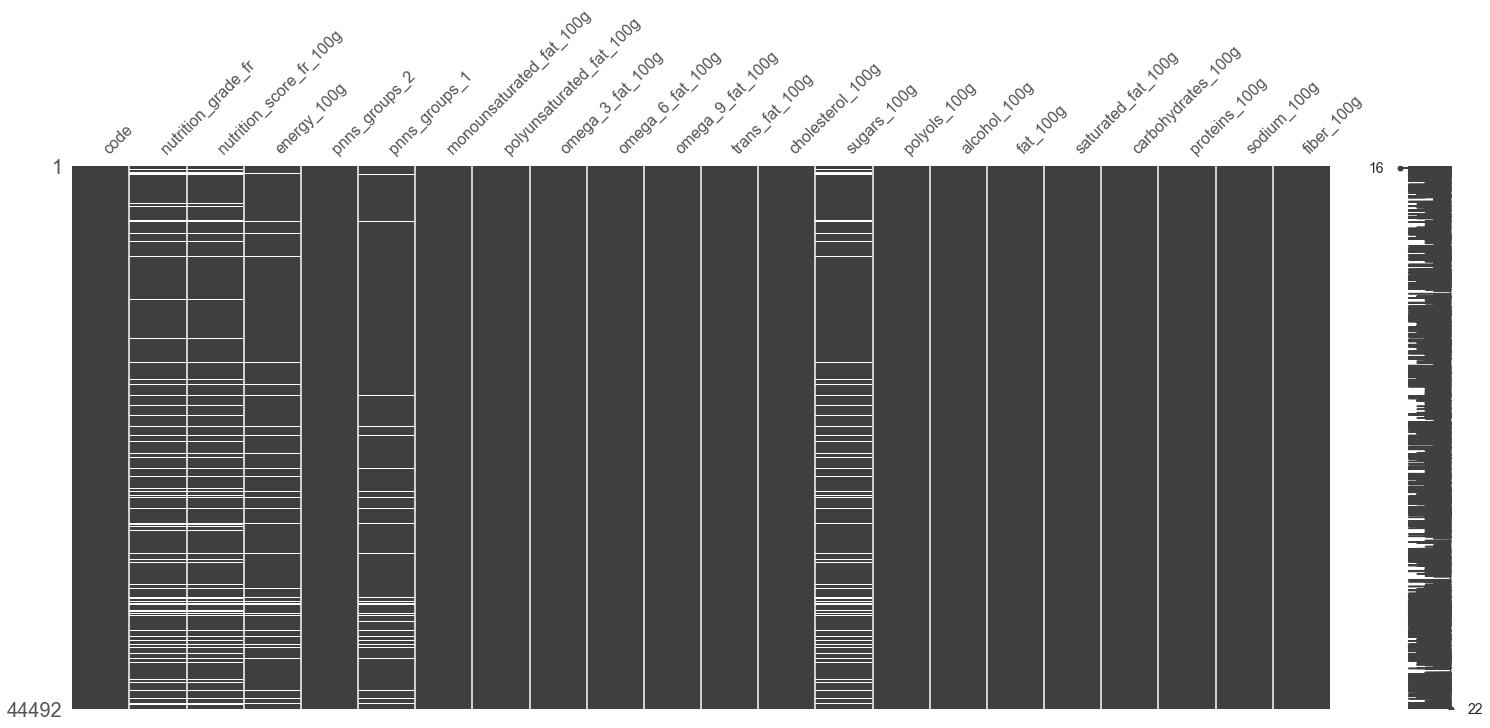

In [88]:
msno.matrix(df_macro_4)

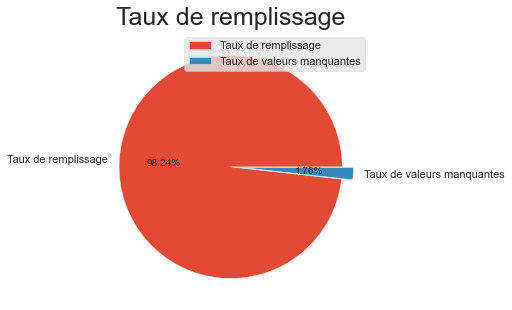

In [89]:
FillRate(df_macro_4)

# 5. Préparation du Dataset pour l'exploration

In [90]:
# Vérifier si il restait des doublons
df_dupl = df_macro_4.copy()
df_dupl = df_dupl.reset_index()
df_dupl['product_name'] = df_dupl.index
df_dupl.index = df_dupl['code']
print('il y a {} doublons.'.format(df_dupl[df_dupl.duplicated()].shape[0]))

il y a 0 doublons.


In [91]:
# Colonnes à supprimer
important_but_empty

['monounsaturated_fat_100g',
 'polyunsaturated_fat_100g',
 'omega_3_fat_100g',
 'omega_6_fat_100g',
 'omega_9_fat_100g',
 'trans_fat_100g',
 'cholesterol_100g',
 'polyols_100g',
 'alcohol_100g']

In [92]:
# Opération de suppression de colonnes inutiles pour l'analyse de données
df_final = df_macro_4.copy()
df_final = df_final.reset_index().dropna()
df_final = df_final[[
'product_name',
'code',
'pnns_groups_2',
'pnns_groups_1',
'nutrition_grade_fr',
'nutrition_score_fr_100g',
'energy_100g',
'carbohydrates_100g',          
'proteins_100g',
'fat_100g',
'saturated_fat_100g',
'sugars_100g',
'fiber_100g',
'sodium_100g',
]]

<AxesSubplot:>

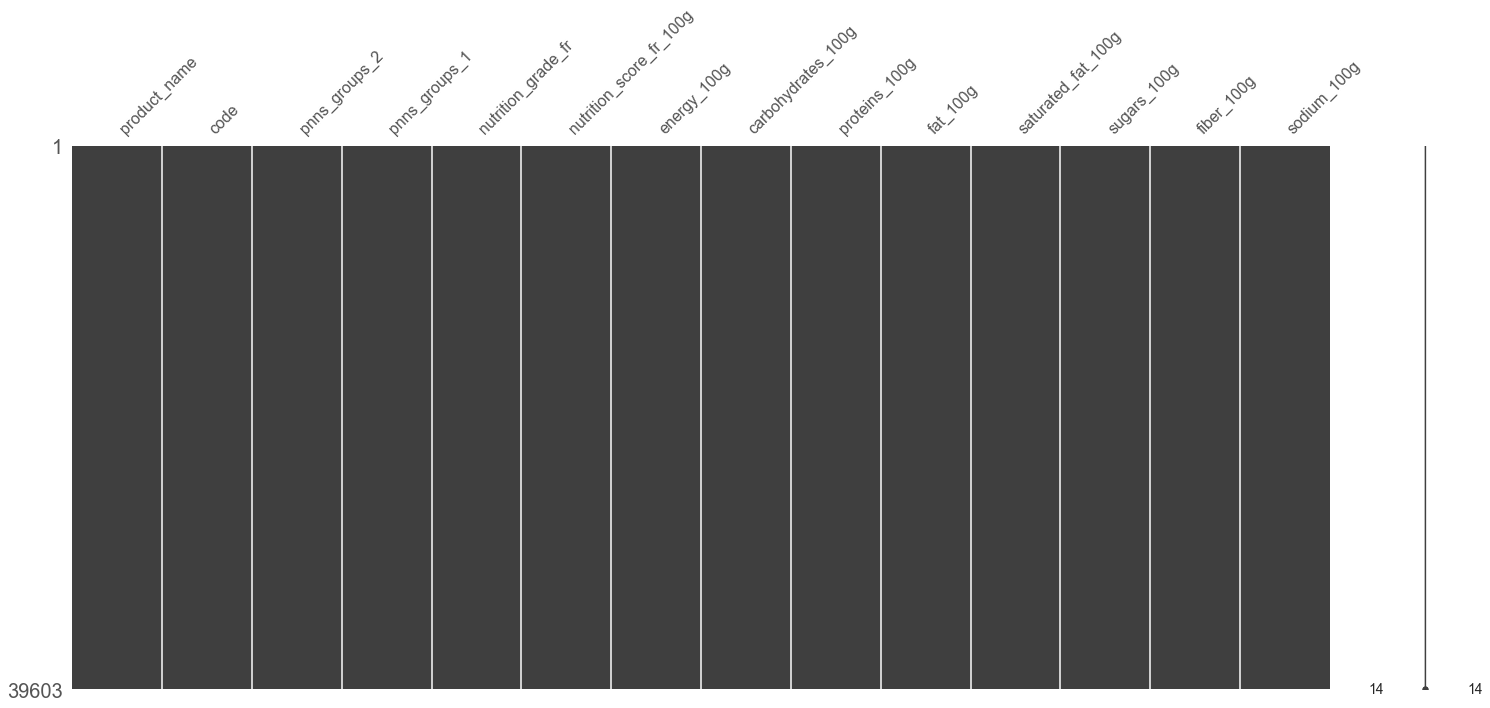

In [93]:
# Etat de santé du DataFrame
msno.matrix(df_final)

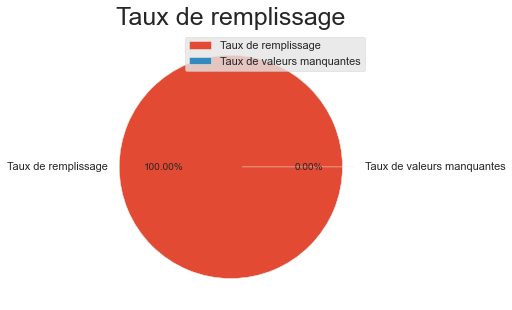

In [94]:
FillRate(df_final)

In [95]:
# Synthèse structure des données
DataStructure(df_final)

,Caractéristiques,Valeurs
0,Nombre de lignes,39603
1,Nombre de colonnes,14
2,Nombre de variables catégorielles,4
3,Nombre de variables numériques,9
4,Pourcentage de données manquantes,0
5,Nombre de doublons,0


In [96]:
df_final = df_final.drop(['code'],axis=1)

In [97]:
df_final.to_csv("cleaned_dataset.csv")